In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
import re
from copy import deepcopy
import matplotlib.image as mpimg
from dataset_handler import df_to_anndata

In [2]:
DIP_df = pd.read_csv('data_subsets/DIP-genes.csv', index_col=0)
DIP_ad = df_to_anndata(DIP_df)
print(DIP_ad)
DIP_df.head(10)

AnnData object with n_obs × n_vars = 2615 × 4
    obs: 'Idents', 'date', 'experiment', 'exp_time'
    var: 0


,DIP-gamma,DIP-beta,DIP-delta,DIP-theta,Idents,date,experiment,exp_time
20190528_CLK856_DD_CT02_AR05_ACAGAC,0,1,2,0,6:DN1p,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_ACTCGA,0,0,1,0,19:DN2,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_AGACCA,0,0,1,0,15:DN1p_CNMa,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_AGGAAG,0,3,1,0,19:DN2,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_CATGCA,1,13,0,1,3:DN1a,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_CTAGTG,0,0,3,1,2:s_LNv,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_GAAGTG,1,0,2,3,7:DN1p,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_GACAAC,0,0,3,0,2:s_LNv,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_GACAGA,0,1,2,2,18:DN1p,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_GAGTAC,0,0,0,0,9:LNd_NPF,2019-05-28,DD,CT02


In [3]:
idents = [ident for ident in DIP_ad.obs['Idents'].unique()]
idents.sort(key= lambda x : int(x.split(':')[0]))
for ident in idents:
    print(ident)

1:DN1p_CNMa
2:s_LNv
3:DN1a
4:DN1p
5:LNd_Trissin
6:DN1p
7:DN1p
8:LN_ITP
9:LNd_NPF
12:LNd
14:DN3
15:DN1p_CNMa
18:DN1p
19:DN2
20:DN3
25:l_LNv
29:LPN


### Part 1: Dot plots

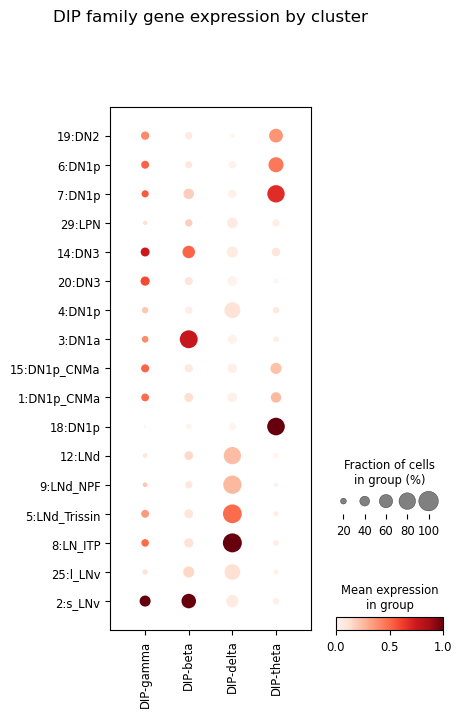

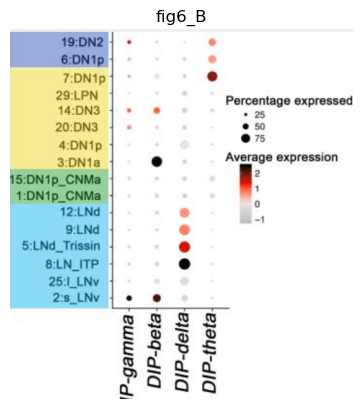

In [95]:
fig6_B = mpimg.imread('fig6_B.png')
reorder = ["19:DN2", "6:DN1p", "7:DN1p", "29:LPN", "14:DN3", "20:DN3", "4:DN1p",
           "3:DN1a", "15:DN1p_CNMa", "1:DN1p_CNMa", "18:DN1p", 
           "12:LNd", "9:LNd_NPF","5:LNd_Trissin", "8:LN_ITP", "25:l_LNv", "2:s_LNv"]
dotplot = sc.pl.DotPlot(DIP_ad,
                        var_names=DIP_ad.var_names,
                        groupby='Idents',
                        categories_order=reorder,
                        standard_scale='var',
                        var_group_rotation=0.,
                        edgecolors=None,
                        mean_only_expressed=True,
                        title='DIP family gene expression by cluster',
                        cmap='Reds',
                        linewidth=0.)
dotplot.DEFAULT_CATEGORY_WIDTH = 0.7
dotplot.DEFAULT_CATEGORY_HEIGHT = 0.4
dotplot.DEFAULT_PLOT_Y_PADDING = 2
dotplot.show()
plt.imshow(fig6_B)
plt.axis('off')
plt.title('fig6_B')
plt.show()

### Part 2: Scatter plots for single gene
First approach: pure matplotlib

In [51]:
fig6_D = mpimg.imread('fig6_D.png')
gene = 'DIP-beta'
df_by_time_DD = DIP_df[(DIP_df['experiment'] == 'DD') & (DIP_df['Idents'] == '2:s_LNv')]\
                      .drop(['experiment', 'Idents', 'date'], axis='columns')\
                      .groupby(['exp_time'])\
                      .mean()\
                      .rename(mapper=lambda x:x[2:], axis='index')
df_by_time_LD = DIP_df[(DIP_df['experiment'] == 'LD') & (DIP_df['Idents'] == '2:s_LNv')]\
                      .drop(['experiment', 'Idents', 'date'], axis='columns')\
                      .groupby(['exp_time'])\
                      .mean()\
                      .rename(mapper=lambda x:x[2:], axis='index')

ad_by_time_DD = sc.AnnData(df_by_time_DD, var=df_by_time_DD.columns.to_frame())
sc.pp.normalize_total(ad_by_time_DD, target_sum=1e4, exclude_highly_expressed=True, inplace=True)
df_by_time_DD_norm = ad_by_time_DD.to_df()
ad_by_time_LD = sc.AnnData(df_by_time_LD, var=df_by_time_LD.columns.to_frame())
sc.pp.normalize_total(ad_by_time_LD, target_sum=1e4, exclude_highly_expressed=True, inplace=True)
df_by_time_LD_norm = ad_by_time_LD.to_df()

C:\Users\gonza\miniconda3\envs\psivenv\Lib\site-packages\scanpy\preprocessing\_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
C:\Users\gonza\miniconda3\envs\psivenv\Lib\site-packages\scanpy\preprocessing\_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


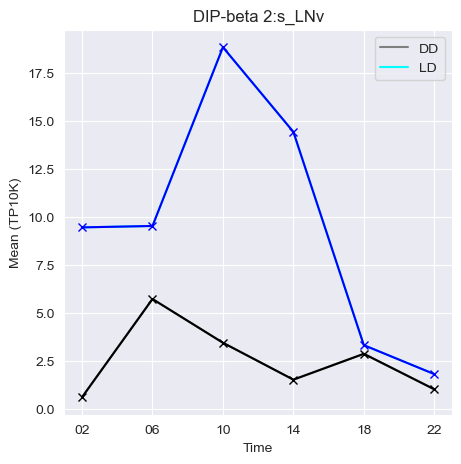

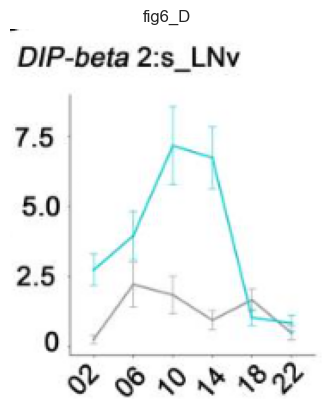

In [53]:
fig, ax = plt.subplots(figsize=(5,5))

ax.errorbar(df_by_time_DD.index, df_by_time_DD_norm[gene], marker='x', c='k')
ax.plot(df_by_time_DD.index, df_by_time_DD_norm[gene], color='gray', label='DD')
ax.errorbar(df_by_time_LD.index, df_by_time_LD_norm[gene], marker='x', c='blue')
ax.plot(df_by_time_LD.index, df_by_time_LD_norm[gene], color='cyan', label='LD')
ax.set_title('DIP-beta 2:s_LNv')
ax.set_xlabel('Time')
ax.set_ylabel('Mean (TP10K)')
plt.legend()
plt.show()

plt.imshow(fig6_D)
plt.axis('off')
plt.title('fig6_D')
plt.show()